In [86]:
import numpy as np
import pandas as pd
import os
from os import listdir
import glob as glob

from nilearn import datasets # for fetching atlas
from nilearn import plotting 
from nilearn import input_data
from nilearn import signal
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
top_dir = '/media/finc/Elements/neurohackademy/fmriprep/'
out_dir = '/media/finc/Elements/neurohackademy/fmriprep/'

#os.listdir(top_dir) 

fmri = glob.glob(top_dir + "sub-*/ses-test/*/*task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc.nii.gz")
confounds_list = glob.glob(top_dir + "sub-*/ses-test/*/*fingerfootlips_bold_confounds.tsv")

len(confounds_list)

10

Step 2: Creating atlas
-------------------------------------------

In [26]:
# Loading Power ROIs coordinates

power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file

power_spheres = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    smoothing_fwhm = 6, 
    radius = 5,
    detrend = True, 
    standardize = True,
    low_pass = 0.08, 
    high_pass = 0.009,
    t_r = 2.5
)

parcellation = power_spheres


In [34]:
#subs = listdir(top_dir)

timeseries_all = np.zeros((len(fmri), 184, 264))

for sub in range(len(fmri)):

        sub_dir = fmri[sub]
        
        # Loading confound data
        confounds_path = confounds_list[sub]
             
        confounds = pd.read_csv(confounds_path, delimiter = '\t')

        # Select columns of interest
        confounds_filtered = confounds[confounds.filter(regex='X|Y|Z|RotX|RotY|RotZ|CSF|WhiteMatter|aCompCor').columns]

        # Save preprocessed confound file
        timeseries = parcellation.fit_transform(fmri[sub], confounds = np.array(confounds_filtered))

        timeseries_all[sub, :, :] = timeseries
            

In [32]:
timeseries.shape

(184, 264)

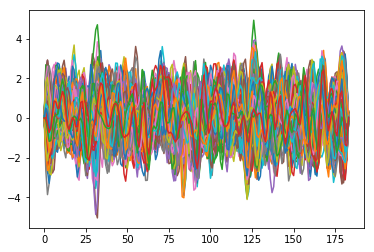

In [36]:
plt.plot(timeseries_all[1,:,:])

Splitting into conditions
=======================================

In [11]:
timeseries

array([[ 0.02312681,  0.01561159,  0.01164729, ..., -0.01980345,
        -0.11118731, -0.06743445],
       [-1.14826542, -1.12292173, -1.23473423, ...,  0.83417777,
         1.23274952,  0.61960414],
       [-1.58914345, -1.74977377, -1.70039413, ...,  1.10920922,
         1.89400097,  0.32407699],
       ..., 
       [-1.57922019, -1.08569849, -1.25319255, ...,  0.8937198 ,
        -1.06369778, -0.07615295],
       [-1.14459714, -0.89229167, -1.01373642, ...,  0.67561487,
        -0.54961723, -0.07952297],
       [ 0.04295532, -0.02164398,  0.01769553, ..., -0.10053585,
        -0.12287441, -0.13058736]])

In [40]:
cond_path = '/home/finc/Dropbox/GitHub/nilearn_task_networks/onsets_fingerfootlips.csv'
conditions = pd.read_csv(cond_path)

conditions

,duration,onset,trial_type
0,15,10,Finger
1,15,40,Foot
2,15,70,Lips
3,15,100,Finger
4,15,130,Foot
5,15,160,Lips
6,15,190,Finger
7,15,220,Foot
8,15,250,Lips
9,15,280,Finger


In [44]:
np.asarray(conditions.onset[conditions['trial_type'] == 'Finger'])

array([ 10, 100, 190, 280, 370])

In [53]:
onsets_lips = np.asarray(conditions.onset[conditions['trial_type'] == 'Lips'])
onsets_finger = np.asarray(conditions.onset[conditions['trial_type'] == 'Finger'])
onsets_foot = np.asarray(conditions.onset[conditions['trial_type'] == 'Foot'])

vol_num = 184
TR = 2.5
duration = 15

tapping = np.zeros((vol_num, 3))

for i in range(len(tapping)):
    if i in onsets_lips/TR:
        for k in range(int(duration/TR)):
            tapping[i + k, 0] = 1
    if i in onsets_finger/TR:
        for k in range(int(duration/TR)):
            tapping[i + k, 1] = 1
    if i in onsets_foot/TR:
        for k in range(int(duration/TR)):
            tapping[i + k, 2] = 1
            
tapping = tapping.astype(bool)        

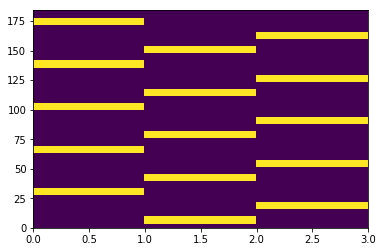

In [54]:
plt.pcolormesh(tapping)
plt.show()

In [63]:
lips = timeseries_all[:, tapping[:, 0], :]
finger = timeseries_all[:, tapping[:, 1], :]
foot = timeseries_all[:, tapping[:, 2], :]

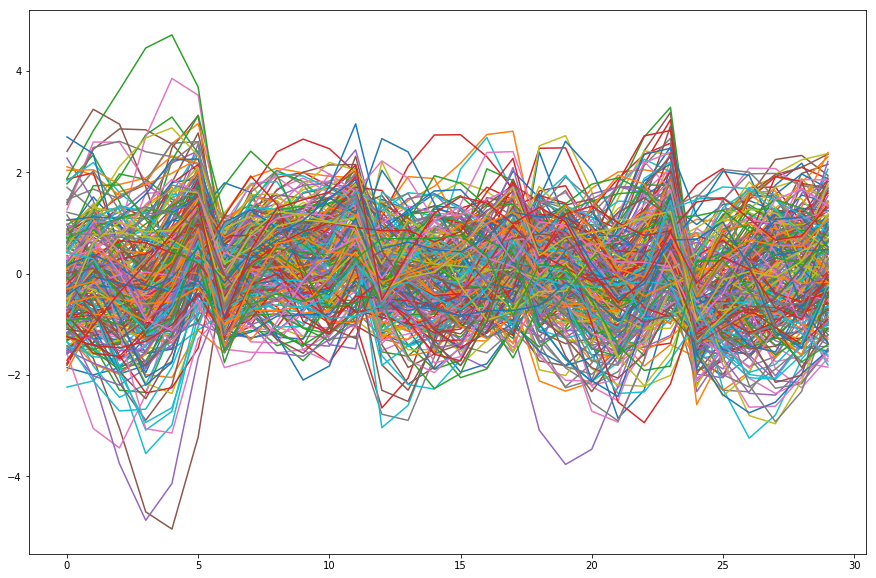

In [68]:
plt.figure(figsize = (15, 10))
_ = plt.plot(lips[1,:,:])

In [69]:
lips.shape

(10, 30, 264)

In [83]:
sub_n = len(timeseries_all[:, 0, 0])
cond_n = 3
rois_n = len(timeseries_all[0, 0, : ])

correlation_matrices = np.zeros((sub_n, cond_n, rois_n, rois_n))

for sub in range(sub_n):  
    
    lips = timeseries_all[sub, tapping[:, 0], :]
    finger = timeseries_all[sub, tapping[:, 1], :]
    foot = timeseries_all[sub, tapping[:, 2], :]
        
    correlation_measure = ConnectivityMeasure(kind = 'correlation')
    
    fc1 = correlation_measure.fit_transform([lips])[0]
    np.fill_diagonal(fc1, 0)
        
    fc2 = correlation_measure.fit_transform([finger])[0]
    np.fill_diagonal(fc2, 0)
    
    fc3 = correlation_measure.fit_transform([foot])[0]
    np.fill_diagonal(fc3, 0)
                              
    correlation_matrices[sub, 0, :, :] = fc1
    correlation_matrices[sub, 1, :, :] = fc2
    correlation_matrices[sub, 2, :, :] = fc3

correlation_matrices.shape

(10, 3, 264, 264)

In [92]:
lips_mean = correlation_matrices[:, 0, :, :].mean(axis = 0)
finger_mean = correlation_matrices[:, 1, :, :].mean(axis = 0)
foot_mean = correlation_matrices[:, 2, :, :].mean(axis = 0)


(10, 264, 264)

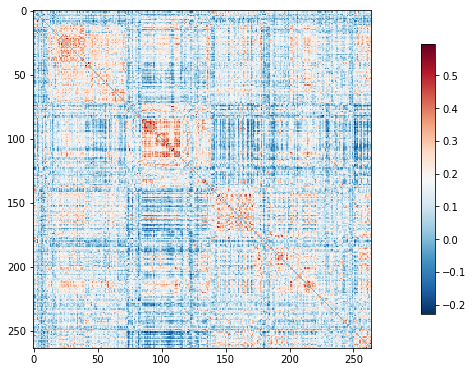

In [88]:
plotting.plot_matrix(lips_mean)

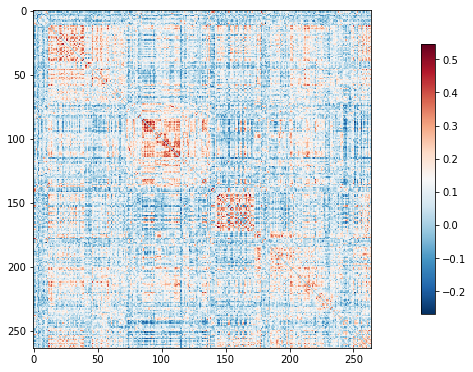

In [89]:
plotting.plot_matrix(finger_mean)

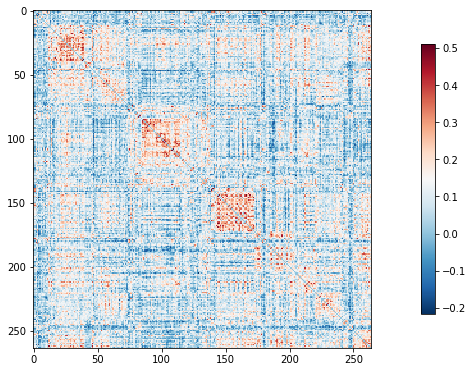

In [90]:
plotting.plot_matrix(foot_mean)

In [96]:
from scipy import stats
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix


lips = sym_matrix_to_vec(correlation_matrices[:, 0, :, :], discard_diagonal = True)
finger = sym_matrix_to_vec(correlation_matrices[:, 1, :, :], discard_diagonal = True)
foot = sym_matrix_to_vec(correlation_matrices[:, 2, :, :], discard_diagonal = True)

In [104]:
stat, pvalues = stats.ttest_rel(lips, foot)

In [107]:
import statsmodels.stats.multitest as ssm

_, pvals_corrected, _, _ = ssm.multipletests(pvalues, alpha = 0.05, method = 'fdr_bh')

pvals_corrected_thr = np.zeros((len(pvals_corrected)))

pvals = np.array([0 if p >= 0.08 else 1 for p in pvals_corrected])


wei_vector = stat * pvals 
diag = np.zeros((264))
matrix = vec_to_sym_matrix(wei_vector, diagonal = diag)
#matrix = vec_to_sym_matrix(pvals_corrected)


matrix_bin = vec_to_sym_matrix(pvals, diagonal = diag)


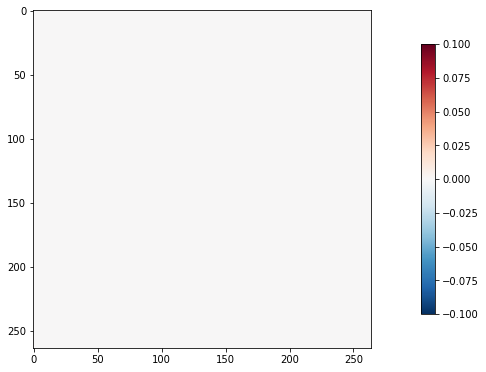

In [108]:
plotting.plot_matrix(matrix)